# Prerequisites

In [1]:
#basic imports and settings
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np

Function to create synthetic datasets:

In [4]:
from sklearn.datasets.samples_generator import make_blobs

def create_data(size_list, k, features=2):
    res = []
    for number in size_list:
        np.random.seed(seed=None)
        a, b = make_blobs(n_samples=number, centers=k, n_features=features)
        res.append(a)
    return res

Function to initliaze centers with different methods

In [5]:
def init_centres(X, k, method):
    if method=="random":
        np.random.seed(seed=604)
        return X[np.random.choice(X.shape[0],k,replace=False),:]
    if method=="k++":
        #pick first point at random
        np.random.seed(seed=604)
        res = X[np.random.choice(X.shape[0],1,replace=False),:]
        #choose subsequent points
        if k>1:
            for j in range(1,k):
                #calculate distances
                Distances = np.array([min([np.linalg.norm(x-p)**2 \
                                        for p in res]) for x in X])
                #model distribution
                pdf = Distances/Distances.sum()
                cdf = pdf.cumsum()
                #choose point
                r = np.random.random()
                choice = np.where(cdf >= r)[0][0]
                #add to result array
                res = np.vstack((res, X[choice]))
            return res
        else:
            return res

# K-means clustering
Serial K-means function:

In [6]:
def sk_means(X, k, seeding="random", ReturnPlot = True): #serial k-means
    if seeding=="random":
        c = init_centres(X, k, method="random")
    else:
        c = init_centres(X, k, method="k++")
    a = np.ndarray([len(X),1], )
    a = a.ravel()
    while True:
        #Assign points to clusters
        for q in range(0, len(a)):
            a[q] = np.argmin([np.linalg.norm(x - X[q]) for x in c])
        #Re-calculate cluster centres
        c_old = c.copy()
        for i in range(0,len(c)):
            c[i,0] = np.mean(X[a==i,0])
            c[i,1] = np.mean(X[a==i,1])
        if np.array_equal(c, c_old):
            if ReturnPlot == True:
                Fig1, ax = plt.subplots()
                for i in range(0,k):
                    ax.plot(X[a==i,0], X[a==i,1], '.')
                ax.plot(c[:,0], c[:,1], 'k^')
                return Fig1
            else:
                return a, c

# Working with Ipython Parallel

Before starting to work with views and engines, it is important to start engines from the terminal. The simplest way to do this is to run from command line (for four engines):

ipcluster start -n 4

Initialize IPython parallel functionalities and requirements:

In [2]:
from ipyparallel import Client
#new client
rc = Client()
rc.purge_everything() #clean old rubbish

#create different views with different number of engines
e_0 = rc[0]
e_all = rc[:]
e_even = rc[::2]
e_odd = rc[1::2]
e_three = rc[1:4:1]

#import numpy and multivariate normal function on engines
for view in (e_0, e_all, e_even, e_odd, e_three):
    with view.sync_imports():
        import numpy
        from scipy.stats import multivariate_normal
    view.block = True

importing numpy on engine(s)
importing multivariate_normal from scipy.stats on engine(s)
importing numpy on engine(s)
importing multivariate_normal from scipy.stats on engine(s)
importing numpy on engine(s)
importing multivariate_normal from scipy.stats on engine(s)
importing numpy on engine(s)
importing multivariate_normal from scipy.stats on engine(s)
importing numpy on engine(s)
importing multivariate_normal from scipy.stats on engine(s)


Parallel K-means:

In [7]:
def pk_means(X, k, view, seeding="random", ReturnPlot = True, ReturnParam = False):
    view.activate()
    if seeding=="random":
        c = init_centres(X, k, method="random")
    else:
        c = init_centres(X, k, method="k++")
    a = np.ndarray([len(X),1], )
    a = a.ravel()
    #partition a (array with cluster indices for each point) across engines
    view.scatter('b', a)
    #object b is non-writable for some reason
    %px a = numpy.ndarray([len(b),1], )
    %px a = a.ravel()
    %px del b
    #partition X (array with points) across engines
    view.scatter('X', X) 
    while True:
        #Assign points to clusters
            #scatter data:
            #push c with cluster centres to all engines
            view['c'] = c
            #identify closest clusters for points remotely on partitioned data
            %px for q in range(0, len(a)): a[q] = \
                numpy.argmin([numpy.linalg.norm(x - X[q]) for x in c])
            #gather data
            a = view.gather('a')#, block=True)

        #Re-calculate cluster centres
            c_old = c.copy()
            for i in range(0,len(c)):
                c[i,0] = np.mean(X[a==i,0])
                c[i,1] = np.mean(X[a==i,1])
            #check if cluster centers moved
            if np.array_equal(c, c_old):
                %px del X, a, c
                if ReturnPlot == True:
                    Fig1, ax = plt.subplots()
                    for i in range(0,k):
                        ax.plot(X[a==i,0], X[a==i,1], '.')
                    ax.plot(c[:,0], c[:,1], 'k^')
                    return Fig1
                if ReturnParam == True: #to get parameters for GMM
                    #centroids, covariance matrices, shares of points in each cluster
                    return c, \
                        np.array([np.cov(X[a==i,], rowvar=False) for i in range(0,k)]), \
                        np.array([sum(a==i)/len(a) for i in range(0,k)])
                else:
                    return a, c

# Gaussian mixture models (GMM)

In [8]:
#packages for GMM function
from scipy.stats import multivariate_normal

In [ ]:
Serial GMM:

In [9]:
def sGMM(X, k, threshold = 0, seeding = "random", ReturnPlots = True):
    #list of log likelihood
    likelihood = []
    ###
    #initialize parameters
    ###
    if seeding == "random":
        mixprop = np.ndarray([k,1],)
        mixprop = mixprop.ravel()
        mixprop[:] = 1/k

        mu = X[np.random.choice(X.shape[0],k,replace=False),:]

        #covariance matrix for sigma
        dimensions = np.shape(X)[1]
        sigma = [np.eye(dimensions)] * k

    if seeding == "kmeans++":
        mu, sigma, mixprop = pk_means(X, k, view, seeding="kmeans++", \
                                      ReturnPlot = False, ReturnParam = True)
        dimensions = np.shape(X)[1]
    if seeding == "kmeans":
        mu, sigma, mixprop = pk_means(X, k, view, seeding="random", \
                                      ReturnPlot = False, ReturnParam = True)
        dimensions = np.shape(X)[1]
    
    #responsibility array
    respon = np.zeros([len(X),k])
    
    #count iterations
    itero = 0
    while True:
        itero = itero + 1
        ###
        #Expectation
        ###
        #denominator for expectation calculation
        den = numpy.array([[mixprop[b]*multivariate_normal.pdf(row, \
                    mean= mu[b], cov=sigma[b]) for b in range(0,k)] \
                    for row in X]).sum(axis = 1)
        #calculate responsibility matrix
        respon = numpy.array([[mixprop[b]*multivariate_normal.pdf(row[1], \
                    mean= mu[b], cov=sigma[b]) / den[row[0]] for b in range(0,k)] \
                    for row in enumerate(X)])             
                
        ###
        #Maximization
        ###
        #remember old parameters
        mu_old = mu.copy()
        sigma_old = sigma.copy()
        mixprop_old = mixprop.copy()
        #calculate number of points in each component
        N_ks = np.sum(respon, axis = 0)
        for j in range(0,k):
            #means mu
            mu[j] = 1. / N_ks[j] * np.sum(respon[:, j] * X.T, axis = 1).T
            x_mu = np.matrix(X - mu[j])
            
            #sigma
            sigma[j] = np.array(1 / N_ks[j] * np.dot(np.multiply(x_mu.T, \
                                                        respon[:, j]), x_mu))
            
            #mixprop
            mixprop[j] = 1. / len(X) * N_ks[j]
        
        #record log likelihood
        likelihood.append(sum(np.log(den)))
        
        #check for convergence
        if threshold > 0 and itero > 1:
            if (likelihood[-1] - likelihood[-2]) < threshold:
                if ReturnPlots == True:
                    Fig0, ax = plt.subplots()
                    ax.plot(range(1,itero+1),likelihood)
                    if dimensions==2:
                        Fig1, ax = plt.subplots()
                        for j in range(0,k):
                            ax.scatter(X[np.argmax(respon, axis=1)==j,0], \
                                       X[np.argmax(respon, axis=1)==j,1], 
                                s=np.max(respon[np.argmax(respon, axis=1)==j], \
                                         axis=1)*10)
                        ax.plot(mu[:,0], mu[:,1], 'k^');
                    return Fig1, Fig0
                else:
                    return mu, sigma, mixprop, respon
        else:
            if np.array_equal(mu_old, mu) and np.array_equal(mixprop_old, mixprop) \
                                        and np.array_equal(sigma_old, sigma):
                if ReturnPlots == True:
                    Fig0, ax = plt.subplots()
                    ax.plot(range(1,itero+1),likelihood)
                    if dimensions==2:
                        Fig1, ax = plt.subplots()
                        for j in range(0,k):
                            ax.scatter(X[np.argmax(respon, axis=1)==j,0], \
                                       X[np.argmax(respon, axis=1)==j,1], \
                                s=np.max(respon[np.argmax(respon, axis=1)==j], \
                                        axis=1)*10)
                        ax.plot(mu[:,0], mu[:,1], 'k^');
                    return Fig1, Fig0
                else:
                    return mu, sigma, mixprop, respon


Parallel GMM:

In [49]:
def pGMM(X, k, view, threshold = 0, seeding = "random", ReturnPlots = True):
    view.activate()
    #list of log likelihood
    likelihood = []
    ###
    #initialize parameters
    ###
    if seeding == "random":
        mixprop = np.ndarray([k,1],)
        mixprop = mixprop.ravel()
        mixprop[:] = 1/k

        mu = X[np.random.choice(X.shape[0],k,replace=False),:]

        #covariance matrix for sigma
        dimensions = np.shape(X)[1]
        sigma = [np.eye(dimensions)] * k

    if seeding == "kmeans++":
        mu, sigma, mixprop = pk_means(X, k, view, seeding="kmeans++", \
                                      ReturnPlot = False, ReturnParam = True)
        dimensions = np.shape(X)[1]
    if seeding == "kmeans":
        mu, sigma, mixprop = pk_means(X, k, view, seeding="random", \
                                      ReturnPlot = False, ReturnParam = True)
        dimensions = np.shape(X)[1]
    #responsibility array
    respon = np.zeros([len(X),k])    
    
    #scatter data points to engines
    view.scatter('X', X) 
    #push k to engines
    view['k'] = k
    
    #count iterations
    itero = 0
    while True:
        itero = itero + 1
        
        ##PARALLELIZATION: push things to engines
        #push (updated) parameters to engines
        view['mu'] = mu
        view['sigma'] = sigma
        view['mixprop'] = mixprop
        #responsibility array
        view.scatter('respon', respon)
        
        ###
        #Expectation
        ###
        
        #denominator for expectation calculation
        %px den = numpy.array([[mixprop[b]*multivariate_normal.pdf(row, \
                        mean= mu[b], cov=sigma[b]) for b in range(0,k)] \
                        for row in X]).sum(axis = 1)
        #calculate responsibility matrix
        %px respon = numpy.array([[mixprop[b]*multivariate_normal.pdf(row[1], \
                        mean= mu[b], cov=sigma[b]) / den[row[0]] for b in range(0,k)] \
                        for row in enumerate(X)])

        
        ##PARALLELIZATION: get things from engines
        respon = view.gather('respon')
        
        ###
        #Maximization
        ###
        #remember old parameters
        mu_old = mu.copy()
        sigma_old = sigma.copy()
        mixprop_old = mixprop.copy()
        #calculate number of points in each component
        N_ks = np.sum(respon, axis = 0)
        for j in range(0,k):
            #means mu
            mu[j] = 1. / N_ks[j] * np.sum(respon[:, j] * X.T, axis = 1).T
            x_mu = np.matrix(X - mu[j])
            
            #sigma
            sigma[j] = np.array(1 / N_ks[j] * np.dot(np.multiply(x_mu.T, \
                                                    respon[:, j]), x_mu))
            
            #mixprop
            mixprop[j] = 1. / len(X) * N_ks[j]
        
        #record log likelihood
        den = view.gather('den')
        likelihood.append(sum(np.log(den)))
        
        #check for convergence
        if threshold > 0 and itero > 1:
            if (likelihood[-1] - likelihood[-2]) < threshold:
                if ReturnPlots == True:
                    Fig0, ax = plt.subplots()
                    ax.plot(range(1,itero+1),likelihood)
                    ax.set_xlabel("iterations")
                    ax.set_ylabel("log likelihood")
                    if dimensions==2:
                        Fig1, ax = plt.subplots()
                        for j in range(0,k):
                            ax.scatter(X[np.argmax(respon, axis=1)==j,0], \
                                       X[np.argmax(respon, axis=1)==j,1], 
                                s=np.max(respon[np.argmax(respon, axis=1)==j],\
                                         axis=1)*10)
                        ax.plot(mu[:,0], mu[:,1], 'k^');
                    return Fig1, Fig0
                else:
                    return mu, sigma, mixprop, respon
        else:
            if np.array_equal(mu_old, mu) and np.array_equal(mixprop_old, mixprop)\
                                            and np.array_equal(sigma_old, sigma):
                if ReturnPlots == True:
                    Fig0, ax = plt.subplots()
                    ax.plot(range(1,itero+1),likelihood)
                    ax.set_xlabel("iterations")
                    ax.set_ylabel("log likelihood")
                    if dimensions==2:
                        Fig1, ax = plt.subplots()
                        for j in range(0,k):
                            ax.scatter(X[np.argmax(respon, axis=1)==j,0], \
                                       X[np.argmax(respon, axis=1)==j,1], 
                                s=np.max(respon[np.argmax(respon, axis=1)==j], \
                                         axis=1)*10)
                        ax.plot(mu[:,0], mu[:,1], 'k^');
                    return Fig1, Fig0
                else:
                    return mu, sigma, mixprop, respon

# Speed experiments

s++ 1 500
1 loop, best of 1: 961 ms per loop
s++ 1 1500
1 loop, best of 1: 2.02 s per loop
s++ 1 2500
1 loop, best of 1: 2.11 s per loop
s++ 1 3500
1 loop, best of 1: 7.23 s per loop
s++ 1 4500
1 loop, best of 1: 7.65 s per loop
s++ 1 5500
1 loop, best of 1: 17.9 s per loop
s++ 1 6500
1 loop, best of 1: 8.77 s per loop
s++ 1 7500
1 loop, best of 1: 10.8 s per loop
s++ 1 8500
1 loop, best of 1: 8.34 s per loop
s++ 1 9500
1 loop, best of 1: 8.84 s per loop
s++ 1 10500
1 loop, best of 1: 19.1 s per loop
s++ 1 11500
1 loop, best of 1: 58.4 s per loop
s++ 1 12500
1 loop, best of 1: 7.82 s per loop
s++ 1 13500
1 loop, best of 1: 7.21 s per loop
s++ 1 14500
1 loop, best of 1: 41.7 s per loop
s++ 1 15500
1 loop, best of 1: 8.53 s per loop
s++ 1 16500
1 loop, best of 1: 28.5 s per loop
s++ 1 17500
1 loop, best of 1: 14.4 s per loop
s++ 1 18500
1 loop, best of 1: 57.1 s per loop
s++ 1 19500
1 loop, best of 1: 13.4 s per loop
p++ four engines 1 500
1 loop, best of 1: 1.75 s per loop
p++ four engi

1 loop, best of 1: 31.4 s per loop
p++ two engines 2 8500
1 loop, best of 1: 14.5 s per loop
p++ two engines 2 9500
1 loop, best of 1: 4.79 s per loop
p++ two engines 2 10500
1 loop, best of 1: 54.4 s per loop
p++ two engines 2 11500
1 loop, best of 1: 13.3 s per loop
p++ two engines 2 12500
1 loop, best of 1: 7.39 s per loop
p++ two engines 2 13500
1 loop, best of 1: 12.2 s per loop
p++ two engines 2 14500
1 loop, best of 1: 31 s per loop
p++ two engines 2 15500
1 loop, best of 1: 54.3 s per loop
p++ two engines 2 16500
1 loop, best of 1: 24.7 s per loop
p++ two engines 2 17500
1 loop, best of 1: 25.1 s per loop
p++ two engines 2 18500
1 loop, best of 1: 1min 2s per loop
p++ two engines 2 19500
1 loop, best of 1: 14.9 s per loop
s++ 3 500
1 loop, best of 1: 433 ms per loop
s++ 3 1500
1 loop, best of 1: 712 ms per loop
s++ 3 2500
1 loop, best of 1: 2.66 s per loop
s++ 3 3500
1 loop, best of 1: 2.59 s per loop
s++ 3 4500
1 loop, best of 1: 6.35 s per loop
s++ 3 5500
1 loop, best of 1: 5

1 loop, best of 1: 10.2 s per loop
p++ three engines 4 15500
1 loop, best of 1: 14.2 s per loop
p++ three engines 4 16500
1 loop, best of 1: 42.4 s per loop
p++ three engines 4 17500
1 loop, best of 1: 39.4 s per loop
p++ three engines 4 18500
1 loop, best of 1: 22.1 s per loop
p++ three engines 4 19500
1 loop, best of 1: 57.2 s per loop
p++ two engines 4 500
1 loop, best of 1: 1.23 s per loop
p++ two engines 4 1500
1 loop, best of 1: 3.55 s per loop
p++ two engines 4 2500
1 loop, best of 1: 1.77 s per loop
p++ two engines 4 3500
1 loop, best of 1: 5.95 s per loop
p++ two engines 4 4500
1 loop, best of 1: 6.8 s per loop
p++ two engines 4 5500
1 loop, best of 1: 8.86 s per loop
p++ two engines 4 6500
1 loop, best of 1: 8.55 s per loop
p++ two engines 4 7500
1 loop, best of 1: 30.2 s per loop
p++ two engines 4 8500
1 loop, best of 1: 20 s per loop
p++ two engines 4 9500
1 loop, best of 1: 13.1 s per loop
p++ two engines 4 10500
1 loop, best of 1: 13.4 s per loop
p++ two engines 4 11500
1

1 loop, best of 1: 1.91 s per loop
p++ three engines 6 2500
1 loop, best of 1: 4.32 s per loop
p++ three engines 6 3500
1 loop, best of 1: 1.98 s per loop
p++ three engines 6 4500
1 loop, best of 1: 4.06 s per loop
p++ three engines 6 5500
1 loop, best of 1: 5.69 s per loop
p++ three engines 6 6500
1 loop, best of 1: 5 s per loop
p++ three engines 6 7500
1 loop, best of 1: 28.2 s per loop
p++ three engines 6 8500
1 loop, best of 1: 32.1 s per loop
p++ three engines 6 9500
1 loop, best of 1: 5.18 s per loop
p++ three engines 6 10500
1 loop, best of 1: 7.11 s per loop
p++ three engines 6 11500
1 loop, best of 1: 10.4 s per loop
p++ three engines 6 12500
1 loop, best of 1: 1min 5s per loop
p++ three engines 6 13500
1 loop, best of 1: 22.2 s per loop
p++ three engines 6 14500
1 loop, best of 1: 33.5 s per loop
p++ three engines 6 15500
1 loop, best of 1: 12.7 s per loop
p++ three engines 6 16500
1 loop, best of 1: 10.8 s per loop
p++ three engines 6 17500
1 loop, best of 1: 10.4 s per loop

1 loop, best of 1: 8.5 s per loop
p++ four engines 8 8500
1 loop, best of 1: 13.8 s per loop
p++ four engines 8 9500
1 loop, best of 1: 20.4 s per loop
p++ four engines 8 10500
1 loop, best of 1: 18.4 s per loop
p++ four engines 8 11500
1 loop, best of 1: 6.79 s per loop
p++ four engines 8 12500
1 loop, best of 1: 23.1 s per loop
p++ four engines 8 13500
1 loop, best of 1: 18.6 s per loop
p++ four engines 8 14500
1 loop, best of 1: 48.9 s per loop
p++ four engines 8 15500
1 loop, best of 1: 9.55 s per loop
p++ four engines 8 16500
1 loop, best of 1: 6.81 s per loop
p++ four engines 8 17500
1 loop, best of 1: 10.6 s per loop
p++ four engines 8 18500
1 loop, best of 1: 11.7 s per loop
p++ four engines 8 19500
1 loop, best of 1: 9.37 s per loop
p++ three engines 8 500
1 loop, best of 1: 2.03 s per loop
p++ three engines 8 1500
1 loop, best of 1: 2.72 s per loop
p++ three engines 8 2500
1 loop, best of 1: 4.3 s per loop
p++ three engines 8 3500
1 loop, best of 1: 2.5 s per loop
p++ three e

1 loop, best of 1: 57.1 s per loop
s++ 10 14500
1 loop, best of 1: 1min per loop
s++ 10 15500
1 loop, best of 1: 35.3 s per loop
s++ 10 16500
1 loop, best of 1: 34.5 s per loop
s++ 10 17500
1 loop, best of 1: 20.4 s per loop
s++ 10 18500
1 loop, best of 1: 1min 9s per loop
s++ 10 19500
1 loop, best of 1: 23.5 s per loop
p++ four engines 10 500
1 loop, best of 1: 1.22 s per loop
p++ four engines 10 1500
1 loop, best of 1: 1.37 s per loop
p++ four engines 10 2500
1 loop, best of 1: 7.02 s per loop
p++ four engines 10 3500
1 loop, best of 1: 3.1 s per loop
p++ four engines 10 4500
1 loop, best of 1: 4.61 s per loop
p++ four engines 10 5500
1 loop, best of 1: 3.68 s per loop
p++ four engines 10 6500
1 loop, best of 1: 12.8 s per loop
p++ four engines 10 7500
1 loop, best of 1: 7.76 s per loop
p++ four engines 10 8500
1 loop, best of 1: 10.6 s per loop
p++ four engines 10 9500
1 loop, best of 1: 44.5 s per loop
p++ four engines 10 10500
1 loop, best of 1: 6.96 s per loop
p++ four engines 10

1 loop, best of 1: 11.2 s per loop
p++ two engines 11 13500
1 loop, best of 1: 33.6 s per loop
p++ two engines 11 14500
1 loop, best of 1: 9.66 s per loop
p++ two engines 11 15500
1 loop, best of 1: 20.5 s per loop
p++ two engines 11 16500
1 loop, best of 1: 59.4 s per loop
p++ two engines 11 17500
1 loop, best of 1: 52.8 s per loop
p++ two engines 11 18500
1 loop, best of 1: 16.9 s per loop
p++ two engines 11 19500
1 loop, best of 1: 11.8 s per loop
s++ 12 500
1 loop, best of 1: 738 ms per loop
s++ 12 1500
1 loop, best of 1: 2.72 s per loop
s++ 12 2500
1 loop, best of 1: 1.15 s per loop
s++ 12 3500
1 loop, best of 1: 1.62 s per loop
s++ 12 4500
1 loop, best of 1: 5.1 s per loop
s++ 12 5500
1 loop, best of 1: 9.44 s per loop
s++ 12 6500
1 loop, best of 1: 4.46 s per loop
s++ 12 7500
1 loop, best of 1: 10.6 s per loop
s++ 12 8500
1 loop, best of 1: 16 s per loop
s++ 12 9500
1 loop, best of 1: 1min 10s per loop
s++ 12 10500
1 loop, best of 1: 20.6 s per loop
s++ 12 11500
1 loop, best of 

1 loop, best of 1: 1min 8s per loop
p++ three engines 13 16500
1 loop, best of 1: 8.08 s per loop
p++ three engines 13 17500
1 loop, best of 1: 19.7 s per loop
p++ three engines 13 18500
1 loop, best of 1: 1min 49s per loop
p++ three engines 13 19500
1 loop, best of 1: 1min 46s per loop
p++ two engines 13 500
1 loop, best of 1: 1.57 s per loop
p++ two engines 13 1500
1 loop, best of 1: 1.43 s per loop
p++ two engines 13 2500
1 loop, best of 1: 2.46 s per loop
p++ two engines 13 3500
1 loop, best of 1: 2.39 s per loop
p++ two engines 13 4500
1 loop, best of 1: 19.7 s per loop
p++ two engines 13 5500
1 loop, best of 1: 6 s per loop
p++ two engines 13 6500
1 loop, best of 1: 12.4 s per loop
p++ two engines 13 7500
1 loop, best of 1: 4.93 s per loop
p++ two engines 13 8500
1 loop, best of 1: 37.5 s per loop
p++ two engines 13 9500
1 loop, best of 1: 13.5 s per loop
p++ two engines 13 10500
1 loop, best of 1: 8.67 s per loop
p++ two engines 13 11500
got unknown result: fcfa461f-0b4e0ea87588

1 loop, best of 1: 16.2 s per loop
p++ three engines 15 500
1 loop, best of 1: 2.14 s per loop
p++ three engines 15 1500
1 loop, best of 1: 3.76 s per loop
p++ three engines 15 2500
1 loop, best of 1: 3.28 s per loop
p++ three engines 15 3500
1 loop, best of 1: 4.37 s per loop
p++ three engines 15 4500
1 loop, best of 1: 7.85 s per loop
p++ three engines 15 5500
1 loop, best of 1: 4.41 s per loop
p++ three engines 15 6500
1 loop, best of 1: 12.7 s per loop
p++ three engines 15 7500
1 loop, best of 1: 9.82 s per loop
p++ three engines 15 8500
1 loop, best of 1: 8.55 s per loop
p++ three engines 15 9500
1 loop, best of 1: 5.23 s per loop
p++ three engines 15 10500
1 loop, best of 1: 8.51 s per loop
p++ three engines 15 11500
1 loop, best of 1: 13.7 s per loop
p++ three engines 15 12500
1 loop, best of 1: 15.8 s per loop
p++ three engines 15 13500
1 loop, best of 1: 51.9 s per loop
p++ three engines 15 14500
1 loop, best of 1: 12 s per loop
p++ three engines 15 15500
1 loop, best of 1: 29

1 loop, best of 1: 5.05 s per loop
p++ four engines 17 3500
1 loop, best of 1: 15 s per loop
p++ four engines 17 4500
1 loop, best of 1: 3.91 s per loop
p++ four engines 17 5500
1 loop, best of 1: 3.57 s per loop
p++ four engines 17 6500
1 loop, best of 1: 10.6 s per loop
p++ four engines 17 7500
1 loop, best of 1: 4.09 s per loop
p++ four engines 17 8500
1 loop, best of 1: 6.54 s per loop
p++ four engines 17 9500
1 loop, best of 1: 12.9 s per loop
p++ four engines 17 10500
1 loop, best of 1: 18.8 s per loop
p++ four engines 17 11500
1 loop, best of 1: 9.8 s per loop
p++ four engines 17 12500
1 loop, best of 1: 51.9 s per loop
p++ four engines 17 13500
1 loop, best of 1: 1min 3s per loop
p++ four engines 17 14500
1 loop, best of 1: 12.1 s per loop
p++ four engines 17 15500
1 loop, best of 1: 13.1 s per loop
p++ four engines 17 16500
1 loop, best of 1: 22.7 s per loop
p++ four engines 17 17500
1 loop, best of 1: 15.5 s per loop
p++ four engines 17 18500
1 loop, best of 1: 1min 52s per l

1 loop, best of 1: 12.4 s per loop
p++ two engines 18 19500
got unknown result: 0037cfbf-d44becdbe279883af6a9b7df
1 loop, best of 1: 43.7 s per loop
s++ 19 500
1 loop, best of 1: 536 ms per loop
s++ 19 1500
1 loop, best of 1: 1.45 s per loop
s++ 19 2500
1 loop, best of 1: 7.99 s per loop
s++ 19 3500
1 loop, best of 1: 7.64 s per loop
s++ 19 4500
1 loop, best of 1: 12.3 s per loop
s++ 19 5500
1 loop, best of 1: 11.5 s per loop
s++ 19 6500
1 loop, best of 1: 22 s per loop
s++ 19 7500
1 loop, best of 1: 22 s per loop
s++ 19 8500
1 loop, best of 1: 7.94 s per loop
s++ 19 9500
1 loop, best of 1: 5.28 s per loop
s++ 19 10500
1 loop, best of 1: 7.37 s per loop
s++ 19 11500
1 loop, best of 1: 13.3 s per loop
s++ 19 12500
1 loop, best of 1: 8.2 s per loop
s++ 19 13500
1 loop, best of 1: 14.5 s per loop
s++ 19 14500
1 loop, best of 1: 14.1 s per loop
s++ 19 15500
1 loop, best of 1: 47.1 s per loop
s++ 19 16500
1 loop, best of 1: 53 s per loop
s++ 19 17500
1 loop, best of 1: 1min 11s per loop
s++

1 loop, best of 1: 3.63 s per loop
p++ two engines 20 3500
1 loop, best of 1: 2.18 s per loop
p++ two engines 20 4500
1 loop, best of 1: 6.57 s per loop
p++ two engines 20 5500
1 loop, best of 1: 8.77 s per loop
p++ two engines 20 6500
1 loop, best of 1: 3.66 s per loop
p++ two engines 20 7500
1 loop, best of 1: 15.1 s per loop
p++ two engines 20 8500
1 loop, best of 1: 33.7 s per loop
p++ two engines 20 9500
1 loop, best of 1: 14.2 s per loop
p++ two engines 20 10500
1 loop, best of 1: 20.4 s per loop
p++ two engines 20 11500
1 loop, best of 1: 6.72 s per loop
p++ two engines 20 12500
1 loop, best of 1: 16.3 s per loop
p++ two engines 20 13500
1 loop, best of 1: 15.3 s per loop
p++ two engines 20 14500
1 loop, best of 1: 25 s per loop
p++ two engines 20 15500
1 loop, best of 1: 27 s per loop
p++ two engines 20 16500
1 loop, best of 1: 15.4 s per loop
p++ two engines 20 17500
1 loop, best of 1: 9.22 s per loop
p++ two engines 20 18500
1 loop, best of 1: 25.5 s per loop
p++ two engines 

1 loop, best of 1: 5.16 s per loop
p++ three engines 22 6500
1 loop, best of 1: 10.9 s per loop
p++ three engines 22 7500
1 loop, best of 1: 9.86 s per loop
p++ three engines 22 8500
1 loop, best of 1: 8.48 s per loop
p++ three engines 22 9500
1 loop, best of 1: 5.57 s per loop
p++ three engines 22 10500
1 loop, best of 1: 7.97 s per loop
p++ three engines 22 11500
1 loop, best of 1: 26.9 s per loop
p++ three engines 22 12500
1 loop, best of 1: 1min 23s per loop
p++ three engines 22 13500
1 loop, best of 1: 25.8 s per loop
p++ three engines 22 14500
1 loop, best of 1: 19 s per loop
p++ three engines 22 15500
1 loop, best of 1: 17.4 s per loop
p++ three engines 22 16500
1 loop, best of 1: 13.7 s per loop
p++ three engines 22 17500
1 loop, best of 1: 10.9 s per loop
p++ three engines 22 18500
1 loop, best of 1: 27 s per loop
p++ three engines 22 19500
1 loop, best of 1: 14.3 s per loop
p++ two engines 22 500
1 loop, best of 1: 1.31 s per loop
p++ two engines 22 1500
1 loop, best of 1: 4.

1 loop, best of 1: 8.39 s per loop
p++ four engines 24 10500
1 loop, best of 1: 4.87 s per loop
p++ four engines 24 11500
1 loop, best of 1: 13.6 s per loop
p++ four engines 24 12500
1 loop, best of 1: 16.7 s per loop
p++ four engines 24 13500
1 loop, best of 1: 41.8 s per loop
p++ four engines 24 14500
1 loop, best of 1: 25.4 s per loop
p++ four engines 24 15500
1 loop, best of 1: 51.6 s per loop
p++ four engines 24 16500
1 loop, best of 1: 17.7 s per loop
p++ four engines 24 17500
1 loop, best of 1: 40.8 s per loop
p++ four engines 24 18500
1 loop, best of 1: 8.98 s per loop
p++ four engines 24 19500
1 loop, best of 1: 1min 58s per loop
p++ three engines 24 500
1 loop, best of 1: 837 ms per loop
p++ three engines 24 1500
1 loop, best of 1: 3.96 s per loop
p++ three engines 24 2500
1 loop, best of 1: 1.88 s per loop
p++ three engines 24 3500
1 loop, best of 1: 8.63 s per loop
p++ three engines 24 4500
1 loop, best of 1: 4.9 s per loop
p++ three engines 24 5500
1 loop, best of 1: 5.18 

1 loop, best of 1: 8.29 s per loop
s++ 26 11500
1 loop, best of 1: 8.6 s per loop
s++ 26 12500
1 loop, best of 1: 14.6 s per loop
s++ 26 13500
1 loop, best of 1: 17 s per loop
s++ 26 14500
1 loop, best of 1: 12.6 s per loop
s++ 26 15500
1 loop, best of 1: 20.9 s per loop
s++ 26 16500
1 loop, best of 1: 43.9 s per loop
s++ 26 17500
1 loop, best of 1: 15.1 s per loop
s++ 26 18500
1 loop, best of 1: 30.9 s per loop
s++ 26 19500
1 loop, best of 1: 17.4 s per loop
p++ four engines 26 500
1 loop, best of 1: 1.09 s per loop
p++ four engines 26 1500
1 loop, best of 1: 1.81 s per loop
p++ four engines 26 2500
1 loop, best of 1: 2.59 s per loop
p++ four engines 26 3500
1 loop, best of 1: 6.79 s per loop
p++ four engines 26 4500
1 loop, best of 1: 3.41 s per loop
p++ four engines 26 5500
1 loop, best of 1: 12.2 s per loop
p++ four engines 26 6500
1 loop, best of 1: 4.73 s per loop
p++ four engines 26 7500
1 loop, best of 1: 17.8 s per loop
p++ four engines 26 8500
1 loop, best of 1: 9.54 s per lo

1 loop, best of 1: 8.75 s per loop
p++ two engines 27 12500
1 loop, best of 1: 12.1 s per loop
p++ two engines 27 13500
1 loop, best of 1: 17.7 s per loop
p++ two engines 27 14500
1 loop, best of 1: 26.3 s per loop
p++ two engines 27 15500
1 loop, best of 1: 10.9 s per loop
p++ two engines 27 16500
1 loop, best of 1: 7.53 s per loop
p++ two engines 27 17500
1 loop, best of 1: 45.1 s per loop
p++ two engines 27 18500
1 loop, best of 1: 9.43 s per loop
p++ two engines 27 19500
1 loop, best of 1: 22 s per loop
s++ 28 500
1 loop, best of 1: 531 ms per loop
s++ 28 1500
1 loop, best of 1: 1.67 s per loop
s++ 28 2500
1 loop, best of 1: 4.91 s per loop
s++ 28 3500
1 loop, best of 1: 2.32 s per loop
s++ 28 4500
1 loop, best of 1: 7.48 s per loop
s++ 28 5500
1 loop, best of 1: 17.8 s per loop
s++ 28 6500
1 loop, best of 1: 17.1 s per loop
s++ 28 7500
1 loop, best of 1: 7.06 s per loop
s++ 28 8500
1 loop, best of 1: 4.64 s per loop
s++ 28 9500
1 loop, best of 1: 28.1 s per loop
s++ 28 10500
1 loo

1 loop, best of 1: 58.5 s per loop
p++ three engines 29 16500
1 loop, best of 1: 12.6 s per loop
p++ three engines 29 17500
1 loop, best of 1: 22.3 s per loop
p++ three engines 29 18500
1 loop, best of 1: 57.3 s per loop
p++ three engines 29 19500
1 loop, best of 1: 18.7 s per loop
p++ two engines 29 500
1 loop, best of 1: 2.4 s per loop
p++ two engines 29 1500
1 loop, best of 1: 1.68 s per loop
p++ two engines 29 2500
1 loop, best of 1: 3.09 s per loop
p++ two engines 29 3500
1 loop, best of 1: 4.55 s per loop
p++ two engines 29 4500
1 loop, best of 1: 4.86 s per loop
p++ two engines 29 5500
1 loop, best of 1: 8.23 s per loop
p++ two engines 29 6500
1 loop, best of 1: 9.72 s per loop
p++ two engines 29 7500
1 loop, best of 1: 5.6 s per loop
p++ two engines 29 8500
got unknown result: 33fdf859-b443d676f41a772532275bf2
1 loop, best of 1: 7.14 s per loop
p++ two engines 29 9500
1 loop, best of 1: 13.6 s per loop
p++ two engines 29 10500
1 loop, best of 1: 21.4 s per loop
p++ two engines 

1 loop, best of 1: 14.8 s per loop
p++ three engines 31 500
1 loop, best of 1: 1.49 s per loop
p++ three engines 31 1500
1 loop, best of 1: 2.36 s per loop
p++ three engines 31 2500
1 loop, best of 1: 7.19 s per loop
p++ three engines 31 3500
1 loop, best of 1: 2.17 s per loop
p++ three engines 31 4500
1 loop, best of 1: 7.1 s per loop
p++ three engines 31 5500
1 loop, best of 1: 6.72 s per loop
p++ three engines 31 6500
1 loop, best of 1: 3.84 s per loop
p++ three engines 31 7500
1 loop, best of 1: 7.93 s per loop
p++ three engines 31 8500
1 loop, best of 1: 12.9 s per loop
p++ three engines 31 9500
1 loop, best of 1: 14.3 s per loop
p++ three engines 31 10500
1 loop, best of 1: 6.2 s per loop
p++ three engines 31 11500
1 loop, best of 1: 5.22 s per loop
p++ three engines 31 12500
1 loop, best of 1: 44.3 s per loop
p++ three engines 31 13500
1 loop, best of 1: 9.81 s per loop
p++ three engines 31 14500
1 loop, best of 1: 1min 28s per loop
p++ three engines 31 15500
1 loop, best of 1: 

1 loop, best of 1: 5.75 s per loop
p++ four engines 33 4500
1 loop, best of 1: 7.7 s per loop
p++ four engines 33 5500
1 loop, best of 1: 3.27 s per loop
p++ four engines 33 6500
1 loop, best of 1: 8.34 s per loop
p++ four engines 33 7500
1 loop, best of 1: 9.07 s per loop
p++ four engines 33 8500
1 loop, best of 1: 8.7 s per loop
p++ four engines 33 9500
1 loop, best of 1: 6.44 s per loop
p++ four engines 33 10500
1 loop, best of 1: 32 s per loop
p++ four engines 33 11500
1 loop, best of 1: 28.4 s per loop
p++ four engines 33 12500
1 loop, best of 1: 8.2 s per loop
p++ four engines 33 13500
1 loop, best of 1: 7.74 s per loop
p++ four engines 33 14500
1 loop, best of 1: 15.3 s per loop
p++ four engines 33 15500
1 loop, best of 1: 35.4 s per loop
p++ four engines 33 16500
1 loop, best of 1: 33.8 s per loop
p++ four engines 33 17500
1 loop, best of 1: 16.2 s per loop
p++ four engines 33 18500
1 loop, best of 1: 17 s per loop
p++ four engines 33 19500
1 loop, best of 1: 31.9 s per loop
p+

1 loop, best of 1: 5.55 s per loop
s++ 35 5500
1 loop, best of 1: 5.59 s per loop
s++ 35 6500
1 loop, best of 1: 19 s per loop
s++ 35 7500
1 loop, best of 1: 5.58 s per loop
s++ 35 8500
1 loop, best of 1: 22.8 s per loop
s++ 35 9500
1 loop, best of 1: 9.04 s per loop
s++ 35 10500
1 loop, best of 1: 33.7 s per loop
s++ 35 11500
1 loop, best of 1: 12.4 s per loop
s++ 35 12500
1 loop, best of 1: 35.4 s per loop
s++ 35 13500
1 loop, best of 1: 11.9 s per loop
s++ 35 14500
1 loop, best of 1: 43 s per loop
s++ 35 15500
1 loop, best of 1: 28.2 s per loop
s++ 35 16500
1 loop, best of 1: 53.4 s per loop
s++ 35 17500
1 loop, best of 1: 23.6 s per loop
s++ 35 18500
1 loop, best of 1: 34.1 s per loop
s++ 35 19500
1 loop, best of 1: 32.1 s per loop
p++ four engines 35 500
1 loop, best of 1: 1.2 s per loop
p++ four engines 35 1500
1 loop, best of 1: 2.17 s per loop
p++ four engines 35 2500
1 loop, best of 1: 3.8 s per loop
p++ four engines 35 3500
1 loop, best of 1: 12.4 s per loop
p++ four engines 

1 loop, best of 1: 4.04 s per loop
p++ two engines 36 8500
1 loop, best of 1: 3.97 s per loop
p++ two engines 36 9500
1 loop, best of 1: 30 s per loop
p++ two engines 36 10500
1 loop, best of 1: 7.44 s per loop
p++ two engines 36 11500
1 loop, best of 1: 34.6 s per loop
p++ two engines 36 12500
1 loop, best of 1: 24 s per loop
p++ two engines 36 13500
1 loop, best of 1: 34.3 s per loop
p++ two engines 36 14500
1 loop, best of 1: 10.6 s per loop
p++ two engines 36 15500
1 loop, best of 1: 9.39 s per loop
p++ two engines 36 16500
1 loop, best of 1: 13.6 s per loop
p++ two engines 36 17500
1 loop, best of 1: 12.8 s per loop
p++ two engines 36 18500
1 loop, best of 1: 11.3 s per loop
p++ two engines 36 19500
1 loop, best of 1: 12.9 s per loop
s++ 37 500
1 loop, best of 1: 630 ms per loop
s++ 37 1500
1 loop, best of 1: 1.29 s per loop
s++ 37 2500
1 loop, best of 1: 1.64 s per loop
s++ 37 3500
1 loop, best of 1: 7.05 s per loop
s++ 37 4500
1 loop, best of 1: 6.37 s per loop
s++ 37 5500
1 loo

1 loop, best of 1: 47.3 s per loop
p++ three engines 38 13500
1 loop, best of 1: 9.69 s per loop
p++ three engines 38 14500
1 loop, best of 1: 37.2 s per loop
p++ three engines 38 15500
1 loop, best of 1: 6.58 s per loop
p++ three engines 38 16500
1 loop, best of 1: 11.5 s per loop
p++ three engines 38 17500
1 loop, best of 1: 8.53 s per loop
p++ three engines 38 18500
1 loop, best of 1: 13.6 s per loop
p++ three engines 38 19500
1 loop, best of 1: 10 s per loop
p++ two engines 38 500
1 loop, best of 1: 1.43 s per loop
p++ two engines 38 1500
1 loop, best of 1: 3.78 s per loop
p++ two engines 38 2500
1 loop, best of 1: 2.43 s per loop
p++ two engines 38 3500
1 loop, best of 1: 7.35 s per loop
p++ two engines 38 4500
1 loop, best of 1: 5.99 s per loop
p++ two engines 38 5500
1 loop, best of 1: 2.89 s per loop
p++ two engines 38 6500
1 loop, best of 1: 5.6 s per loop
p++ two engines 38 7500
1 loop, best of 1: 10.8 s per loop
p++ two engines 38 8500
1 loop, best of 1: 5.23 s per loop
p++ 

1 loop, best of 1: 18.9 s per loop
p++ four engines 40 18500
1 loop, best of 1: 1min 36s per loop
p++ four engines 40 19500
1 loop, best of 1: 35.1 s per loop
p++ three engines 40 500
1 loop, best of 1: 1.86 s per loop
p++ three engines 40 1500
1 loop, best of 1: 3.05 s per loop
p++ three engines 40 2500
1 loop, best of 1: 7.2 s per loop
p++ three engines 40 3500
1 loop, best of 1: 4.55 s per loop
p++ three engines 40 4500
1 loop, best of 1: 6.64 s per loop
p++ three engines 40 5500
1 loop, best of 1: 21.8 s per loop
p++ three engines 40 6500
1 loop, best of 1: 26 s per loop
p++ three engines 40 7500
1 loop, best of 1: 13.9 s per loop
p++ three engines 40 8500
1 loop, best of 1: 20.4 s per loop
p++ three engines 40 9500
1 loop, best of 1: 13.2 s per loop
p++ three engines 40 10500
1 loop, best of 1: 17.4 s per loop
p++ three engines 40 11500
1 loop, best of 1: 11.3 s per loop
p++ three engines 40 12500
1 loop, best of 1: 47.3 s per loop
p++ three engines 40 13500
1 loop, best of 1: 7.5

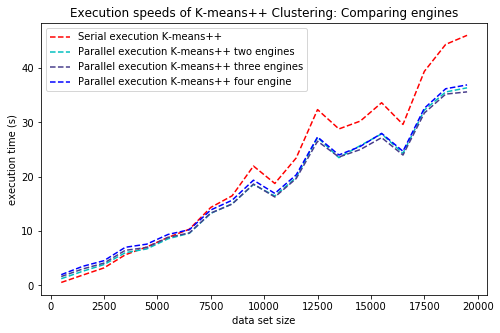

In [9]:
#####################################################################
#Speed experiment: K-means++, serial vs parallel, different #engines#
#####################################################################

from matplotlib.offsetbox import AnchoredText
dataset_size = np.arange(500,20000,1000)

#Average over many random datasets:
rloops = 40

#######
# k=5 #
#######
rk = 5

for u in range(1,rloops+1):
    XX = create_data(dataset_size, rk)
    lds = len(dataset_size)

    #RECORD TIMINGS
    ts9 = np.zeros([lds,5],)
    ts9[:,0]=dataset_size

    #serial k means plus plus
    for i in range(0,lds):
        print("s++",u, len(XX[i]))
        z = %timeit -n1 -r1 -o sk_means(XX[i], rk, seeding="k++", ReturnPlot = False)
        ts9[i,1] = z.best

    #parallel k means plus plus, all engines
    for i in range(0,lds):
        print("p++ four engines",u, len(XX[i]))
        z = %timeit -n1 -r1 -o pk_means(XX[i], rk, e_odd, seeding="k++", ReturnPlot = False)
        ts9[i,2] = z.best
    
    #parallel k means plus plus, three engines
    for i in range(0,lds):
        print("p++ three engines",u, len(XX[i]))
        z = %timeit -n1 -r1 -o pk_means(XX[i], rk, e_three, seeding="k++", ReturnPlot = False)
        ts9[i,3] = z.best

    #parallel k means plus plus, two engines
    for i in range(0,lds):
        print("p++ two engines",u, len(XX[i]))
        z = %timeit -n1 -r1 -o pk_means(XX[i], rk, e_all, seeding="k++", ReturnPlot = False)
        ts9[i,4] = z.best
        
    if u == 1:
        tst9 = ts9
    else:
        tst9 = np.dstack((tst9,ts9))

#calculate mean values
ts9 = numpy.mean(tst9, axis=2)


################
#     plot     #
################
feng, ax = plt.subplots(1, figsize=(8,5))

ax.plot(ts9[:,0], ts9[:,1], 'r--', label="Serial execution K-means++")
ax.plot(ts9[:,0], ts9[:,2], 'c--', label="Parallel execution K-means++ two engines")
ax.plot(ts9[:,0], ts9[:,3], linestyle='--', color='DarkSlateBlue', label="Parallel execution K-means++ three engines")
ax.plot(ts9[:,0], ts9[:,4], 'b--', label="Parallel execution K-means++ four engine")

ax.set_title("Execution speeds of K-means++ Clustering: Comparing engines")
ax.set_xlabel("data set size")
ax.set_ylabel("execution time (s)")
ax.legend();

feng.savefig("f_skmeans_vs_pkmeans_quad.jpg", format="jpg", bbox_inches="tight")
feng.savefig("f_skmeans_vs_pkmeans_quad.eps", format="eps", bbox_inches="tight")

#plt.savefig("f_skmeans_vs_pkmeans_dual.jpg", format="jpg", bbox_inches="tight")
#plt.savefig("f_skmeans_vs_pkmeans_dual.eps", format="eps", bbox_inches="tight")


sGMM 1 500
1 loop, best of 1: 4.17 s per loop
sGMM 1 600
1 loop, best of 1: 5.35 s per loop
pGMM 1 500
1 loop, best of 1: 3.22 s per loop
pGMM 1 600
1 loop, best of 1: 4.32 s per loop
sGMM 2 500
1 loop, best of 1: 2.14 s per loop
sGMM 2 600
1 loop, best of 1: 2.61 s per loop
pGMM 2 500
got unknown result: 1aec73e8-e5c7f577f2e45990ce6a1633
1 loop, best of 1: 3.34 s per loop
pGMM 2 600
got unknown result: b90463ba-76255f12ba588963b5d51161
got unknown result: 1612ab2f-af9144f4b0bf81eacc0043a7
1 loop, best of 1: 4.24 s per loop
sGMM 1 500
1 loop, best of 1: 2.93 s per loop
sGMM 1 600
1 loop, best of 1: 3.45 s per loop
pGMM 1 500
1 loop, best of 1: 3.44 s per loop
pGMM 1 600
got unknown result: 526d03e3-315875add31ba99f01804d90
1 loop, best of 1: 4.75 s per loop
sGMM 2 500
got unknown result: 43413e4f-fc88bf47f44902fd1d21bc7c
1 loop, best of 1: 5.73 s per loop
sGMM 2 600
1 loop, best of 1: 20.4 s per loop
pGMM 2 500
1 loop, best of 1: 4.27 s per loop
pGMM 2 600
got unknown result: 78bedbed-

NameError: name 'f_skmeans_vs_pkmeans' is not defined

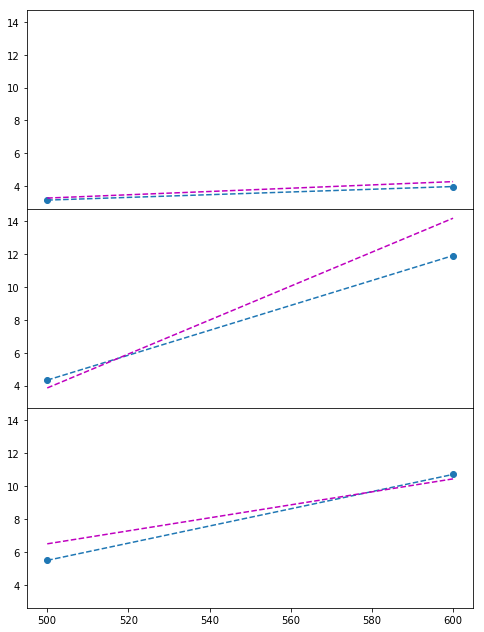

In [28]:
###############################################################
#Speed experiment: GMM++, serial vs parallel, different ks#
###############################################################

from matplotlib.offsetbox import AnchoredText
#dataset_size = np.arange(500,30000,1000)
dataset_size = np.arange(500,650,100)

#Average over many random datasets:
rloops = 2 #100
#GMM-threshold for convergence
thresh = 0.0001

#######
# k=2 #
#######
rk = 2

for u in range(1,rloops+1):
    XX = create_data(dataset_size, rk)
    lds = len(dataset_size)

    #RECORD TIMINGS
    ts2 = np.zeros([lds,3],)
    ts2[:,0]=dataset_size

    #serial GMM, initliazed through kmeans++
    for i in range(0,lds):
        print("sGMM",u, len(XX[i]))
        z = %timeit -n1 -r1 -o sGMM(X=XX[i], k=rk, threshold = thresh, seeding="kmeans++", ReturnPlots=False)
        ts2[i,1] = z.best

                
    #parallel GMM, initialized through kmeans++
    for i in range(0,lds):
        print("pGMM",u, len(XX[i]))
        z = %timeit -n1 -r1 -o pGMM(X=XX[i], k=rk, threshold = thresh, seeding="kmeans++", view = e_all, ReturnPlots=False)
        ts2[i,2] = z.best
        
    if u == 1:
        tst2 = ts2
    else:
        tst2 = np.dstack((tst2,ts2))

#calculate mean values
ts2 = numpy.mean(tst2, axis=2)

#######
# k=3 #
#######
rk = 3

for u in range(1,rloops+1):
    XX = create_data(dataset_size, rk)
    lds = len(dataset_size)

    #RECORD TIMINGS
    ts3 = np.zeros([lds,3],)
    ts3[:,0]=dataset_size

    #serial GMM, initliazed through kmeans++
    for i in range(0,lds):
        print("sGMM",u, len(XX[i]))
        z = %timeit -n1 -r1 -o sGMM(X=XX[i], k=rk, threshold = thresh, seeding="kmeans++", ReturnPlots=False)
        ts3[i,1] = z.best

    #parallel GMM, initialized through kmeans++
    for i in range(0,lds):
        print("pGMM",u, len(XX[i]))
        z = %timeit -n1 -r1 -o pGMM(X=XX[i], k=rk, threshold = thresh, seeding="kmeans++", view = e_all, ReturnPlots=False)
        ts3[i,2] = z.best
        
    if u == 1:
        tst3 = ts3
    else:
        tst3 = np.dstack((tst3,ts3))

#calculate mean values
ts3 = numpy.mean(tst3, axis=2)

#######
# k=4 #
#######
rk = 4

for u in range(1,rloops+1):
    XX = create_data(dataset_size, rk)
    lds = len(dataset_size)

    #RECORD TIMINGS
    ts4 = np.zeros([lds,3],)
    ts4[:,0]=dataset_size

    #serial GMM, initliazed through kmeans++
    for i in range(0,lds):
        print("sGMM",u, len(XX[i]))
        z = %timeit -n1 -r1 -o sGMM(X=XX[i], k=rk, threshold = thresh, seeding="kmeans++", ReturnPlots=False)
        ts4[i,1] = z.best

    #parallel GMM, initialized through kmeans++
    for i in range(0,lds):
        print("pGMM",u, len(XX[i]))
        z = %timeit -n1 -r1 -o pGMM(X=XX[i], k=rk, threshold = thresh, seeding="kmeans++", view = e_all, ReturnPlots=False)

        ts4[i,2] = z.best
        
    if u == 1:
        tst4 = ts4
    else:
        tst4 = np.dstack((tst4,ts4))

#calculate mean values
ts4 = numpy.mean(tst4, axis=2)

################
#     plot     #
################
f_sGMM_vs_pGMM, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,11), sharex=True, sharey=True)

#ax1 for plot where k=2
ax1.plot(ts2[:,0], ts2[:,1], color='orange', linestyle='--', label="Serial execution GMM")
ax1.plot(ts2[:,0], ts2[:,2], 'm--', label="Parallel execution GMM")

#ax2 for plot where k=3
ax2.plot(ts3[:,0], ts3[:,1], color='orange', linestyle='--', label="Serial execution GMM")
ax2.plot(ts3[:,0], ts3[:,2], 'm--', label="Parallel execution GMM")

#ax3 for plot where k=4
ax3.plot(ts4[:,0], ts4[:,1], color='orange', linestyle='--', label="Serial execution GMM")
ax3.plot(ts4[:,0], ts4[:,2], 'm--', label="Parallel execution GMM")

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f_sGMM_vs_pGMM.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f_sGMM_vs_pGMM.axes[:-1]], visible=False)

#add labels etc.
ax3.set_xlabel("data set size")
ax2.set_ylabel("execution time (s)")

ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax1.add_artist(AnchoredText("k=2", loc=2))
ax2.add_artist(AnchoredText("k=3", loc=2))
ax3.add_artist(AnchoredText("k=4", loc=2))

#f_sGMM_vs_pGMM.savefig("f_sGMM_vs_pGMM.eps", format="eps", bbox_inches="tight")
#f_sGMM_vs_pGMM.savefig("f_sGMM_vs_pGMM.jpg", format="jpg", bbox_inches="tight")

In [ ]:
###############################################################
#Speed experiment: K-means++, serial vs parallel, different ks#
###############################################################

from matplotlib.offsetbox import AnchoredText
dataset_size = np.arange(500,30000,1000)

#Average over many random datasets:
rloops = 250

#######
# k=2 #
#######
rk = 2

for u in range(1,rloops+1):
    XX = create_data(dataset_size, rk)
    lds = len(dataset_size)

    #RECORD TIMINGS
    ts2 = np.zeros([lds,3],)
    ts2[:,0]=dataset_size

    #serial k means plus plus
    for i in range(0,lds):
        print("s++",u, len(XX[i]))
        z = %timeit -n1 -r1 -o sk_means(XX[i], rk, seeding="k++",\
                                        ReturnPlot = False)
        ts2[i,1] = z.best

    #parallel k means plus plus
    for i in range(0,lds):
        print("p++",u, len(XX[i]))
        z = %timeit -n1 -r1 -o pk_means(XX[i], rk, e_all, seeding="k++",\
                                        ReturnPlot = False)
        ts2[i,2] = z.best
        
    if u == 1:
        tst2 = ts2
    else:
        tst2 = np.dstack((tst2,ts2))

#calculate mean values
ts2 = numpy.mean(tst2, axis=2)

#######
# k=3 #
#######
rk = 3

for u in range(1,rloops+1):
    XX = create_data(dataset_size, rk)
    lds = len(dataset_size)

    #RECORD TIMINGS
    ts3 = np.zeros([lds,3],)
    ts3[:,0]=dataset_size

    #serial k means plus plus
    for i in range(0,lds):
        print("s++",u, len(XX[i]))
        z = %timeit -n1 -r1 -o sk_means(XX[i], rk, seeding="k++",\
                                        ReturnPlot = False)
        ts3[i,1] = z.best

    #parallel k means plus plus
    for i in range(0,lds):
        print("p++",u, len(XX[i]))
        z = %timeit -n1 -r1 -o pk_means(XX[i], rk, e_all, seeding="k++",\
                                        ReturnPlot = False)
        ts3[i,2] = z.best
        
    if u == 1:
        tst3 = ts3
    else:
        tst3 = np.dstack((tst3,ts3))

#calculate mean values
ts3 = numpy.mean(tst3, axis=2)

#######
# k=4 #
#######
rk = 4

for u in range(1,rloops+1):
    XX = create_data(dataset_size, rk)
    lds = len(dataset_size)

    #RECORD TIMINGS
    ts4 = np.zeros([lds,3],)
    ts4[:,0]=dataset_size

    #serial k means plus plus
    for i in range(0,lds):
        print("s++",u, len(XX[i]))
        z = %timeit -n1 -r1 -o sk_means(XX[i], rk, seeding="k++",\
                                        ReturnPlot = False)
        ts4[i,1] = z.best

    #parallel k means plus plus
    for i in range(0,lds):
        print("p++",u, len(XX[i]))
        z = %timeit -n1 -r1 -o pk_means(XX[i], rk, e_all, seeding="k++",\
                                        ReturnPlot = False)
        ts4[i,2] = z.best
        
    if u == 1:
        tst4 = ts4
    else:
        tst4 = np.dstack((tst4,ts4))

#calculate mean values
ts4 = numpy.mean(tst4, axis=2)

################
#     plot     #
################
f_skmeans_vs_pkmeans, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,11),\
                                                sharex=True, sharey=True)

#ax1 for plot where k=2
ax1.plot(ts2[:,0], ts2[:,1], 'r--', label="Serial execution K-means++")
ax1.plot(ts2[:,0], ts2[:,2], 'b--', label="Parallel execution K-means++")

#ax2 for plot where k=3
ax2.plot(ts3[:,0], ts3[:,1], 'r--', label="Serial execution K-means++")
ax2.plot(ts3[:,0], ts3[:,2], 'b--', label="Parallel execution K-means++")

#ax3 for plot where k=4
ax3.plot(ts4[:,0], ts4[:,1], 'r--', label="Serial execution K-means++")
ax3.plot(ts4[:,0], ts4[:,2], 'b--', label="Parallel execution K-means++")

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f_skmeans_vs_pkmeans.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f_skmeans_vs_pkmeans.axes[:-1]],\
                                                 visible=False)

#add labels etc.
ax3.set_xlabel("data set size")
ax2.set_ylabel("execution time (s)")

ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax1.add_artist(AnchoredText("k=2", loc=2))
ax2.add_artist(AnchoredText("k=3", loc=2))
ax3.add_artist(AnchoredText("k=4", loc=2))

#f_skmeans_vs_pkmeans.savefig("f_skmeans_vs_pkmeans.eps", format="eps",\
                             bbox_inches="tight")
#f_skmeans_vs_pkmeans.savefig("f_skmeans_vs_pkmeans.jpg", format="jpg",\
                             bbox_inches="tight")

got unknown result: 83768513-8dceec596cfaae5c65cff08b


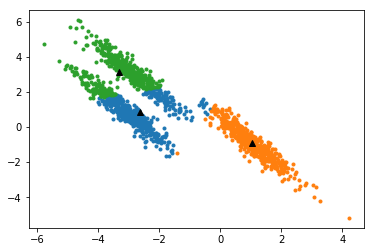

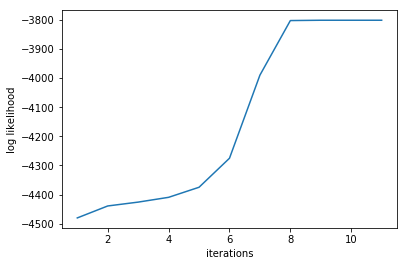

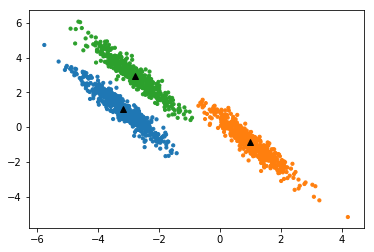

In [53]:
#compare k-means to GMM on anisotropic data
#create sammple data

n_samples = 1500
X, y = make_blobs(n_samples=n_samples, centers=3, random_state = 170)

# Anisotropicly distributed data
transformation = [[ 0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X = np.dot(X, transformation)

#add grid
#V = np.zeros([130,2],)
#V[:,0] = list(np.linspace(-6,3,10)) * 13
#V[:,1] = list(np.linspace(-4,8,13)) * 10

#X = np.vstack((X,V))

#k-means
a = pk_means(X, k=3, view=e_all, seeding="k++", ReturnPlot = True)

#GMM
b, c = pGMM(X, k=3, threshold = 0.001, seeding="kmeans++", view = e_all, ReturnPlots=True)
